In [1]:
import requests, json, os
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
pd.set_option('display.max_columns', None)

In [2]:
history = pd.read_csv('./data/2019-20/gameweek_history.csv')[
    ['id', 'fixture', 'minutes', 'goals_scored', 'assists', 'clean_sheets', 
     'goals_conceded', 'own_goals', 'penalties_saved', 'penalties_missed', 'yellow_cards', 'red_cards',
     'saves', 'bonus', 'bps', 'was_home', 'influence', 'creativity', 'threat', 'ict_index', 'total_points']]

players = pd.read_csv('./data/2019-20/players.csv')[
    ['id', 'first_name', 'second_name', 'web_name', 'element_type', 'team']]

teams = pd.read_csv('./data/2019-20/teams.csv').rename(columns={'id': 'team_id', 'short_name': 'team'})

positions = pd.read_csv('./data/2019-20/positions.csv').rename(columns={'id': 'element_type', 'name_short': 'position'})

In [3]:
history.head()

,id,fixture,minutes,goals_scored,assists,clean_sheets,goals_conceded,own_goals,penalties_saved,penalties_missed,yellow_cards,red_cards,saves,bonus,bps,was_home,influence,creativity,threat,ict_index,total_points
0,449,1,0,0,0,0,0,0,0,0,0,0,0,0,0,False,0.0,0.0,0,0.0,0
1,454,1,0,0,0,0,0,0,0,0,0,0,0,0,0,False,0.0,0.0,0,0.0,0
2,507,1,0,0,0,0,0,0,0,0,0,0,0,0,0,False,0.0,0.0,0,0.0,0
3,289,1,0,0,0,0,0,0,0,0,0,0,0,0,0,False,0.0,0.0,0,0.0,0
4,275,1,0,0,0,0,0,0,0,0,0,0,0,0,0,False,0.0,0.0,0,0.0,0


In [4]:
players.head()

,id,first_name,second_name,web_name,element_type,team
0,7,Laurent,Koscielny,Koscielny,2,1
1,8,Konstantinos,Mavropanos,Mavropanos,2,1
2,9,Carl,Jenkinson,Jenkinson,2,1
3,585,Tyreece,John-Jules,John-Jules,4,1
4,636,Zech,Medley,Medley,2,1


In [5]:
teams.head()

,team_id,name,team,strength,strength_overall_home,strength_overall_away,strength_attack_home,strength_attack_away,strength_defence_home,strength_defence_away
0,1,Arsenal,ARS,4,1180,1240,1170,1170,1150,1200
1,2,Aston Villa,AVL,2,1020,1050,970,980,1000,1040
2,3,Bournemouth,BOU,2,1020,1020,990,1030,1000,1050
3,4,Brighton,BHA,2,1050,1010,1100,1100,1040,1030
4,5,Burnley,BUR,3,1110,1180,1130,1070,970,1110


In [6]:
positions.head()

,element_type,plural_name,position,singular_name
0,1,Goalkeepers,GKP,Goalkeeper
1,2,Defenders,DEF,Defender
2,3,Midfielders,MID,Midfielder
3,4,Forwards,FWD,Forward


In [7]:
df = players.merge(positions[['element_type', 'position']], on='element_type')  # add player positions
df = df.merge(teams[['team_id', 'team']], left_on='team', right_on='team_id', suffixes=('_x', None))  # add teams
df = df.merge(history, on='id')  # add gameweek history
df.drop(['element_type', 'team_x', 'team_id'], axis=1, inplace=True)
df.sort_values(['id', 'fixture'], inplace=True)
df = df[df['minutes']>0]
df.head(10)

,id,first_name,second_name,web_name,position,team,fixture,minutes,goals_scored,assists,clean_sheets,goals_conceded,own_goals,penalties_saved,penalties_missed,yellow_cards,red_cards,saves,bonus,bps,was_home,influence,creativity,threat,ict_index,total_points
426,1,Shkodran,Mustafi,Mustafi,DEF,ARS,137,90,0,1,0,2,0,0,0,0,0,0,0,24,False,19.8,0.8,54,7.5,4
424,1,Shkodran,Mustafi,Mustafi,DEF,ARS,182,13,0,0,0,0,0,0,0,0,0,0,0,3,False,2.8,0.2,0,0.3,1
425,1,Shkodran,Mustafi,Mustafi,DEF,ARS,191,67,0,0,0,2,0,0,0,0,0,0,0,8,True,9.6,0.2,0,1.0,1
434,1,Shkodran,Mustafi,Mustafi,DEF,ARS,221,90,0,0,0,1,0,0,0,0,0,0,0,14,True,24.6,1.2,19,4.5,2
427,1,Shkodran,Mustafi,Mustafi,DEF,ARS,238,90,0,1,0,2,0,0,0,0,0,0,1,28,False,54.8,10.5,2,6.7,5
428,1,Shkodran,Mustafi,Mustafi,DEF,ARS,242,90,0,0,1,0,0,0,0,0,0,0,0,24,False,17.2,0.3,4,2.2,6
429,1,Shkodran,Mustafi,Mustafi,DEF,ARS,251,90,0,0,1,0,0,0,0,0,0,0,0,24,True,19.4,1.4,24,4.5,6
430,1,Shkodran,Mustafi,Mustafi,DEF,ARS,261,90,0,0,0,2,0,0,0,0,0,0,0,19,True,26.0,0.8,4,3.1,1
422,1,Shkodran,Mustafi,Mustafi,DEF,ARS,275,90,0,0,0,3,0,0,0,0,0,0,0,8,False,8.8,0.0,0,0.9,1
431,1,Shkodran,Mustafi,Mustafi,DEF,ARS,293,90,0,0,0,2,0,0,0,0,0,0,0,17,False,24.4,25.7,17,6.7,1


In [8]:
df.shape

(10614, 26)

In [9]:
X = df[['position', 'influence', 'creativity', 'threat']]
y = df['total_points']

In [10]:
ohe = OneHotEncoder()
scaler = StandardScaler()

In [11]:
# select columns by data type
num_cols = make_column_selector(dtype_include='number')
cat_cols = make_column_selector(dtype_include='object')

In [12]:
preprocessor = make_column_transformer(
    (scaler, num_cols),
    (ohe, cat_cols)
)

In [13]:
pipe = make_pipeline(preprocessor, RandomForestRegressor())

In [14]:
# cross-validate the pipeline
cross_val_score(pipe, X, y).mean()

0.5330055069920869

In [15]:
pipe.fit(X, y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000028A81AF62B0>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000028AFCAB0070>)])),
                ('randomforestregressor', RandomForestRegressor())])

In [16]:
df['prediction'] = pipe.predict(X)
df.head()

,id,first_name,second_name,web_name,position,team,fixture,minutes,goals_scored,assists,clean_sheets,goals_conceded,own_goals,penalties_saved,penalties_missed,yellow_cards,red_cards,saves,bonus,bps,was_home,influence,creativity,threat,ict_index,total_points,prediction
426,1,Shkodran,Mustafi,Mustafi,DEF,ARS,137,90,0,1,0,2,0,0,0,0,0,0,0,24,False,19.8,0.8,54,7.5,4,3.880000
424,1,Shkodran,Mustafi,Mustafi,DEF,ARS,182,13,0,0,0,0,0,0,0,0,0,0,0,3,False,2.8,0.2,0,0.3,1,0.961667
425,1,Shkodran,Mustafi,Mustafi,DEF,ARS,191,67,0,0,0,2,0,0,0,0,0,0,0,8,True,9.6,0.2,0,1.0,1,1.080500
434,1,Shkodran,Mustafi,Mustafi,DEF,ARS,221,90,0,0,0,1,0,0,0,0,0,0,0,14,True,24.6,1.2,19,4.5,2,3.083333
427,1,Shkodran,Mustafi,Mustafi,DEF,ARS,238,90,0,1,0,2,0,0,0,0,0,0,1,28,False,54.8,10.5,2,6.7,5,6.397500


<AxesSubplot:xlabel='total_points', ylabel='prediction'>

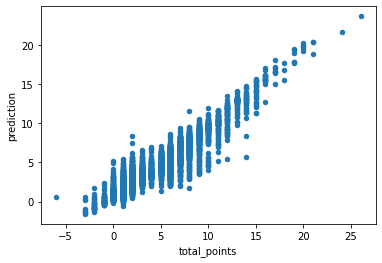

In [17]:
df.plot('total_points', 'prediction', kind='scatter')